In [1]:
import kagglehub
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

Using Colab cache for faster access to the 'face-expression-recognition-dataset' dataset.


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import itertools
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Multiply, Reshape
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam



In [3]:
print(os.listdir("/kaggle/input/face-expression-recognition-dataset"))

['images']


In [4]:
base_path = path
#"E:\data science project\images\train"
for expression in os.listdir(base_path + "/images/train/"):
    print(str(len(os.listdir(base_path + "/images/train/" + expression))) + " " + expression + " images")

3205 surprise images
4103 fear images
3993 angry images
4982 neutral images
4938 sad images
436 disgust images
7164 happy images


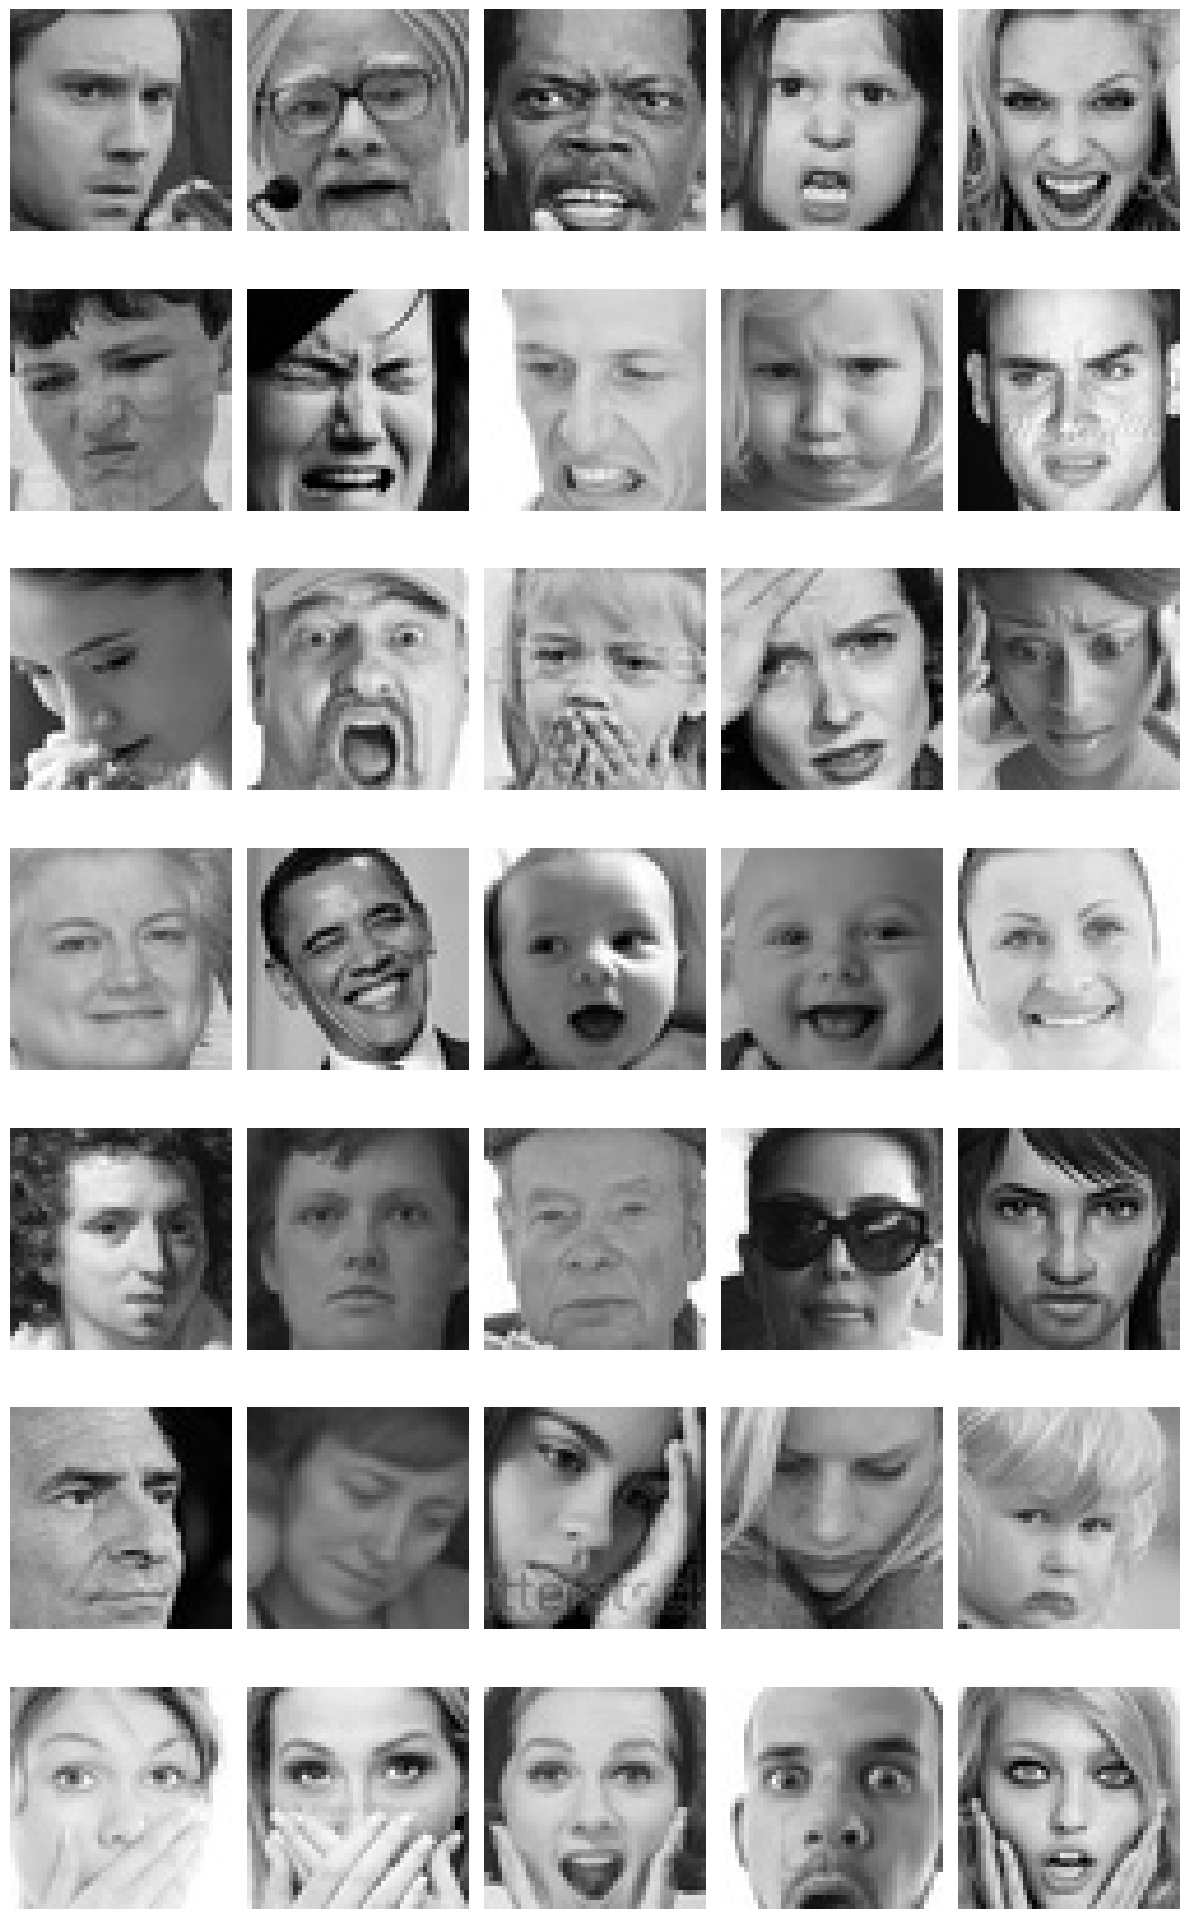

In [5]:
pic_size = 48

plt.figure(0, figsize=(12,20))
cpt = 0

train_dir = os.path.join(base_path, "images/train")
classes = sorted(os.listdir(train_dir))
# show up to 5 images per class, safe against small folders
for expression in classes:
    expr_dir = os.path.join(train_dir, expression)
    image_files = sorted(os.listdir(expr_dir))
    if not image_files:
        continue
    sample_files = image_files[:5]  # pick first up-to-5 images
    for filename in sample_files:
        cpt += 1
        plt.subplot(len(classes), 5, cpt)
        img_path = os.path.join(expr_dir, filename)
        img = load_img(img_path, target_size=(pic_size, pic_size))
        plt.imshow(img)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
batch_size = 128


# Optimized Data Augmentation (Reduced shifts/zoom for 48x48 images)
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,      # Reduced from 30
    width_shift_range=0.1,  # Reduced from 0.3 (to keep face centered)
    height_shift_range=0.1, # Reduced from 0.3
    shear_range=0.1,
    zoom_range=0.1,         # Reduced from 0.2
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], # Slightly less aggressive brightness changes
    fill_mode='nearest'
)


datagen_validation = ImageDataGenerator(rescale=1./255)


train_generator = datagen_train.flow_from_directory(
    path + "/images/train",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


validation_generator = datagen_validation.flow_from_directory(
    path + "/images/validation",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Keep shuffle=False for predictable validation steps
)


# Get the labels directly from the generator to ensure order matches folder names
train_labels = train_generator.classes


# Calculate weights automatically using the 'balanced' heuristic
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)


# Convert to dictionary for Keras (index 0 corresponds to the first class alphabetically, etc.)
class_weights = dict(enumerate(class_weights_array))


print("Mapped Class Weights:", class_weights)
print("Generator Class Indices:", train_generator.class_indices)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Mapped Class Weights: {0: np.float64(1.031125898894494), 1: np.float64(9.443315858453474), 2: np.float64(1.0034817729187702), 3: np.float64(0.5747188322565207), 4: np.float64(0.8264322991340254), 5: np.float64(0.8337962159347335), 6: np.float64(1.2846445286382884)}
Generator Class Indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [7]:
classes = 7
model = Sequential()


# Block 1: Double Conv (Output: 48x48 -> 24x24)
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Block 2: Double Conv (Output: 24x24 -> 12x12)
model.add(Conv2D(128, (3,3), padding='same')) # Changed from 5x5
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Block 3: Double Conv (Output: 12x12 -> 6x6)
model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Block 4: Double Conv (Output: 6x6 -> 3x3)
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Classification Head
model.add(GlobalAveragePooling2D())


model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(classes, activation='softmax'))


# Lowered learning rate for the deeper model
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 256)    │             

 Total params: 4,960,199 (18.92 MB)

 Trainable params: 4,955,335 (18.90 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [8]:
epochs = 70
nn = 30
# 1. Checkpoint
checkpoint = ModelCheckpoint(
    "model_weights.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)


# 2. Early Stopping
early_stop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = nn, # Wait nn epochs for improvement before stopping
    verbose = 1,
    restore_best_weights = True
)


# 3. LR Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)


callbacks_list = [checkpoint, early_stop, lr_scheduler]



steps_per_epoch = math.ceil(train_generator.n / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.n / validation_generator.batch_size)



history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks_list,
    class_weight = class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.1488 - loss: 2.3301
Epoch 1: val_accuracy improved from -inf to 0.11987, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 217s 853ms/step - accuracy: 0.1489 - loss: 2.3296 - val_accuracy: 0.1199 - val_loss: 2.0200 - learning_rate: 5.0000e-04
Epoch 2/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.1909 - loss: 2.0757
Epoch 2: val_accuracy improved from 0.11987 to 0.25828, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 64s 284ms/step - accuracy: 0.1910 - loss: 2.0755 - val_accuracy: 0.2583 - val_loss: 1.8977 - learning_rate: 5.0000e-04
Epoch 3/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.2364 - loss: 1.9460
Epoch 3: val_accuracy did not improve from 0.25828
226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - accuracy: 0.2365 - loss: 1.9458 - val_accuracy: 0.1977 - val_loss: 1.9267 - learning_rate: 5.0000e-04
Epoch 4/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3135 - loss: 1.8047
Epoch 4: val_accuracy improved from 0.25828 to 0.41353, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 290ms/step - accuracy: 0.3136 - loss: 1.8046 - val_accuracy: 0.4135 - val_loss: 1.5929 - learning_rate: 5.0000e-04
Epoch 5/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.3795 - loss: 1.6477
Epoch 5: val_accuracy did not improve from 0.41353
226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 293ms/step - accuracy: 0.3796 - loss: 1.6476 - val_accuracy: 0.3245 - val_loss: 2.3683 - learning_rate: 5.0000e-04
Epoch 6/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4093 - loss: 1.5726
Epoch 6: val_accuracy improved from 0.41353 to 0.44693, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - accuracy: 0.4093 - loss: 1.5726 - val_accuracy: 0.4469 - val_loss: 1.4810 - learning_rate: 5.0000e-04
Epoch 7/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4408 - loss: 1.4669
Epoch 7: val_accuracy improved from 0.44693 to 0.45174, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 64s 283ms/step - accuracy: 0.4408 - loss: 1.4669 - val_accuracy: 0.4517 - val_loss: 1.4509 - learning_rate: 5.0000e-04
Epoch 8/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4670 - loss: 1.4079
Epoch 8: val_accuracy improved from 0.45174 to 0.47028, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 293ms/step - accuracy: 0.4670 - loss: 1.4078 - val_accuracy: 0.4703 - val_loss: 1.4412 - learning_rate: 5.0000e-04
Epoch 9/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4826 - loss: 1.3663
Epoch 9: val_accuracy improved from 0.47028 to 0.53722, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - accuracy: 0.4826 - loss: 1.3662 - val_accuracy: 0.5372 - val_loss: 1.2439 - learning_rate: 5.0000e-04
Epoch 10/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4944 - loss: 1.3098
Epoch 10: val_accuracy did not improve from 0.53722
226/226 ━━━━━━━━━━━━━━━━━━━━ 63s 278ms/step - accuracy: 0.4944 - loss: 1.3098 - val_accuracy: 0.4383 - val_loss: 1.4896 - learning_rate: 5.0000e-04
Epoch 11/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5180 - loss: 1.2763
Epoch 11: val_accuracy did not improve from 0.53722
226/226 ━━━━━━━━━━━━━━━━━━━━ 63s 280ms/step - accuracy: 0.5180 - loss: 1.2763 - val_accuracy: 0.3954 - val_loss: 1.8359 - learning_rate: 5.0000e-04
Epoch 12/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5120 - loss: 1.2561
Epoch 12: val_accuracy did not improve from 0.53722
226/226 ━━━━━━━━━━━━━━━━━━━━ 63s 280ms/step - accuracy: 0.5121 - loss: 1.2560 - val_accuracy: 0.4948 - val_loss: 1.3146 - learning_ra

226/226 ━━━━━━━━━━━━━━━━━━━━ 65s 288ms/step - accuracy: 0.5307 - loss: 1.1926 - val_accuracy: 0.5375 - val_loss: 1.2237 - learning_rate: 5.0000e-04
Epoch 14/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5359 - loss: 1.2074
Epoch 14: val_accuracy did not improve from 0.53750
226/226 ━━━━━━━━━━━━━━━━━━━━ 67s 297ms/step - accuracy: 0.5360 - loss: 1.2074 - val_accuracy: 0.5342 - val_loss: 1.2126 - learning_rate: 5.0000e-04
Epoch 15/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5409 - loss: 1.1574
Epoch 15: val_accuracy did not improve from 0.53750
226/226 ━━━━━━━━━━━━━━━━━━━━ 67s 295ms/step - accuracy: 0.5409 - loss: 1.1574 - val_accuracy: 0.5044 - val_loss: 1.3247 - learning_rate: 5.0000e-04
Epoch 16/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5525 - loss: 1.1378
Epoch 16: val_accuracy improved from 0.53750 to 0.58237, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - accuracy: 0.5524 - loss: 1.1378 - val_accuracy: 0.5824 - val_loss: 1.1116 - learning_rate: 5.0000e-04
Epoch 17/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5587 - loss: 1.1245
Epoch 17: val_accuracy did not improve from 0.58237
226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - accuracy: 0.5586 - loss: 1.1246 - val_accuracy: 0.5446 - val_loss: 1.2529 - learning_rate: 5.0000e-04
Epoch 18/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5627 - loss: 1.1198
Epoch 18: val_accuracy improved from 0.58237 to 0.58463, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 290ms/step - accuracy: 0.5627 - loss: 1.1197 - val_accuracy: 0.5846 - val_loss: 1.1199 - learning_rate: 5.0000e-04
Epoch 19/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5649 - loss: 1.1117
Epoch 19: val_accuracy did not improve from 0.58463
226/226 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - accuracy: 0.5649 - loss: 1.1118 - val_accuracy: 0.5509 - val_loss: 1.1844 - learning_rate: 5.0000e-04
Epoch 20/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5737 - loss: 1.0776
Epoch 20: val_accuracy did not improve from 0.58463
226/226 ━━━━━━━━━━━━━━━━━━━━ 75s 334ms/step - accuracy: 0.5736 - loss: 1.0777 - val_accuracy: 0.5512 - val_loss: 1.1975 - learning_rate: 5.0000e-04
Epoch 21/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5755 - loss: 1.1008
Epoch 21: val_accuracy did not improve from 0.58463
226/226 ━━━━━━━━━━━━━━━━━━━━ 82s 363ms/step - accuracy: 0.5755 - loss: 1.1007 - val_accuracy: 0.5742 - val_loss: 1.0951 - learning_ra

226/226 ━━━━━━━━━━━━━━━━━━━━ 77s 338ms/step - accuracy: 0.5917 - loss: 1.0284 - val_accuracy: 0.5960 - val_loss: 1.0883 - learning_rate: 5.0000e-04
Epoch 24/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5822 - loss: 1.0587
Epoch 24: val_accuracy did not improve from 0.59595
226/226 ━━━━━━━━━━━━━━━━━━━━ 65s 285ms/step - accuracy: 0.5822 - loss: 1.0587 - val_accuracy: 0.5224 - val_loss: 1.3068 - learning_rate: 5.0000e-04
Epoch 25/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5908 - loss: 1.0153
Epoch 25: val_accuracy did not improve from 0.59595
226/226 ━━━━━━━━━━━━━━━━━━━━ 64s 283ms/step - accuracy: 0.5908 - loss: 1.0153 - val_accuracy: 0.4962 - val_loss: 1.4257 - learning_rate: 5.0000e-04
Epoch 26/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5965 - loss: 1.0026
Epoch 26: val_accuracy did not improve from 0.59595
226/226 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step - accuracy: 0.5965 - loss: 1.0026 - val_accuracy: 0.5374 - val_loss: 1.2362 - learning_ra

226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - accuracy: 0.5966 - loss: 1.0098 - val_accuracy: 0.5999 - val_loss: 1.0749 - learning_rate: 5.0000e-04
Epoch 29/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6110 - loss: 0.9775
Epoch 29: val_accuracy did not improve from 0.59992
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.6110 - loss: 0.9775 - val_accuracy: 0.5992 - val_loss: 1.0763 - learning_rate: 5.0000e-04
Epoch 30/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6136 - loss: 0.9613
Epoch 30: val_accuracy improved from 0.59992 to 0.61831, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - accuracy: 0.6136 - loss: 0.9613 - val_accuracy: 0.6183 - val_loss: 1.0282 - learning_rate: 5.0000e-04
Epoch 31/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6128 - loss: 0.9572
Epoch 31: val_accuracy did not improve from 0.61831
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.6127 - loss: 0.9572 - val_accuracy: 0.4931 - val_loss: 1.4938 - learning_rate: 5.0000e-04
Epoch 32/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6164 - loss: 0.9521
Epoch 32: val_accuracy did not improve from 0.61831
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - accuracy: 0.6164 - loss: 0.9522 - val_accuracy: 0.6001 - val_loss: 1.0658 - learning_rate: 5.0000e-04
Epoch 33/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6170 - loss: 0.9531
Epoch 33: val_accuracy improved from 0.61831 to 0.62213, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accuracy: 0.6170 - loss: 0.9532 - val_accuracy: 0.6221 - val_loss: 1.0155 - learning_rate: 5.0000e-04
Epoch 34/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6198 - loss: 0.9312
Epoch 34: val_accuracy did not improve from 0.62213
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 237ms/step - accuracy: 0.6198 - loss: 0.9313 - val_accuracy: 0.6221 - val_loss: 1.0050 - learning_rate: 5.0000e-04
Epoch 35/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6313 - loss: 0.9239
Epoch 35: val_accuracy improved from 0.62213 to 0.63558, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.6313 - loss: 0.9239 - val_accuracy: 0.6356 - val_loss: 1.0050 - learning_rate: 5.0000e-04
Epoch 36/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6215 - loss: 0.9472
Epoch 36: val_accuracy improved from 0.63558 to 0.63756, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 237ms/step - accuracy: 0.6215 - loss: 0.9472 - val_accuracy: 0.6376 - val_loss: 0.9721 - learning_rate: 5.0000e-04
Epoch 37/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6239 - loss: 0.9239
Epoch 37: val_accuracy did not improve from 0.63756
226/226 ━━━━━━━━━━━━━━━━━━━━ 53s 236ms/step - accuracy: 0.6239 - loss: 0.9239 - val_accuracy: 0.5921 - val_loss: 1.0942 - learning_rate: 5.0000e-04
Epoch 38/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6324 - loss: 0.9075
Epoch 38: val_accuracy did not improve from 0.63756
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - accuracy: 0.6324 - loss: 0.9075 - val_accuracy: 0.5943 - val_loss: 1.0952 - learning_rate: 5.0000e-04
Epoch 39/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6315 - loss: 0.9032
Epoch 39: val_accuracy did not improve from 0.63756
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.6315 - loss: 0.9032 - val_accuracy: 0.6277 - val_loss: 1.0062 - learning_ra

226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.6482 - loss: 0.8649 - val_accuracy: 0.6612 - val_loss: 0.9299 - learning_rate: 2.5000e-04
Epoch 43/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6663 - loss: 0.8190
Epoch 43: val_accuracy did not improve from 0.66119
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.6663 - loss: 0.8190 - val_accuracy: 0.6281 - val_loss: 1.0252 - learning_rate: 2.5000e-04
Epoch 44/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6598 - loss: 0.8270
Epoch 44: val_accuracy did not improve from 0.66119
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accuracy: 0.6598 - loss: 0.8270 - val_accuracy: 0.6496 - val_loss: 0.9575 - learning_rate: 2.5000e-04
Epoch 45/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6606 - loss: 0.8227
Epoch 45: val_accuracy improved from 0.66119 to 0.66402, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - accuracy: 0.6606 - loss: 0.8227 - val_accuracy: 0.6640 - val_loss: 0.9348 - learning_rate: 2.5000e-04
Epoch 46/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6705 - loss: 0.8082
Epoch 46: val_accuracy did not improve from 0.66402
226/226 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - accuracy: 0.6705 - loss: 0.8082 - val_accuracy: 0.6637 - val_loss: 0.9202 - learning_rate: 2.5000e-04
Epoch 47/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6749 - loss: 0.7931
Epoch 47: val_accuracy did not improve from 0.66402
226/226 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - accuracy: 0.6749 - loss: 0.7932 - val_accuracy: 0.6584 - val_loss: 0.9335 - learning_rate: 2.5000e-04
Epoch 48/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6621 - loss: 0.8019
Epoch 48: val_accuracy did not improve from 0.66402
226/226 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - accuracy: 0.6621 - loss: 0.8019 - val_accuracy: 0.6540 - val_loss: 0.9723 - learning_ra

226/226 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - accuracy: 0.6731 - loss: 0.7960 - val_accuracy: 0.6705 - val_loss: 0.9102 - learning_rate: 2.5000e-04
Epoch 50/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6749 - loss: 0.7786
Epoch 50: val_accuracy did not improve from 0.67053
226/226 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - accuracy: 0.6749 - loss: 0.7786 - val_accuracy: 0.6519 - val_loss: 0.9643 - learning_rate: 2.5000e-04
Epoch 51/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6812 - loss: 0.7796
Epoch 51: val_accuracy did not improve from 0.67053
226/226 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - accuracy: 0.6812 - loss: 0.7796 - val_accuracy: 0.6490 - val_loss: 0.9803 - learning_rate: 2.5000e-04
Epoch 52/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6810 - loss: 0.7658
Epoch 52: val_accuracy did not improve from 0.67053
226/226 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - accuracy: 0.6810 - loss: 0.7659 - val_accuracy: 0.6524 - val_loss: 0.9703 - learning_ra

226/226 ━━━━━━━━━━━━━━━━━━━━ 83s 257ms/step - accuracy: 0.6945 - loss: 0.7389 - val_accuracy: 0.6738 - val_loss: 0.9155 - learning_rate: 1.2500e-04
Epoch 56/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6913 - loss: 0.7417
Epoch 56: val_accuracy improved from 0.67379 to 0.67747, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - accuracy: 0.6912 - loss: 0.7417 - val_accuracy: 0.6775 - val_loss: 0.9239 - learning_rate: 1.2500e-04
Epoch 57/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7054 - loss: 0.7209
Epoch 57: val_accuracy improved from 0.67747 to 0.68087, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - accuracy: 0.7053 - loss: 0.7210 - val_accuracy: 0.6809 - val_loss: 0.9152 - learning_rate: 1.2500e-04
Epoch 58/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6934 - loss: 0.7487
Epoch 58: val_accuracy did not improve from 0.68087
226/226 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - accuracy: 0.6934 - loss: 0.7487 - val_accuracy: 0.6752 - val_loss: 0.9254 - learning_rate: 1.2500e-04
Epoch 59/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7030 - loss: 0.7266
Epoch 59: val_accuracy did not improve from 0.68087
226/226 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - accuracy: 0.7030 - loss: 0.7266 - val_accuracy: 0.6591 - val_loss: 0.9640 - learning_rate: 1.2500e-04
Epoch 60/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7033 - loss: 0.7115
Epoch 60: val_accuracy did not improve from 0.68087
226/226 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - accuracy: 0.7032 - loss: 0.7116 - val_accuracy: 0.6718 - val_loss: 0.9292 - learning_ra

226/226 ━━━━━━━━━━━━━━━━━━━━ 57s 251ms/step - accuracy: 0.7100 - loss: 0.6943 - val_accuracy: 0.6843 - val_loss: 0.9002 - learning_rate: 6.2500e-05
Epoch 66/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7109 - loss: 0.6923
Epoch 66: val_accuracy did not improve from 0.68426
226/226 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - accuracy: 0.7109 - loss: 0.6923 - val_accuracy: 0.6795 - val_loss: 0.9157 - learning_rate: 6.2500e-05
Epoch 67/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7124 - loss: 0.6856
Epoch 67: val_accuracy did not improve from 0.68426
226/226 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - accuracy: 0.7124 - loss: 0.6856 - val_accuracy: 0.6834 - val_loss: 0.9087 - learning_rate: 6.2500e-05
Epoch 68/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7097 - loss: 0.6831
Epoch 68: val_accuracy improved from 0.68426 to 0.68511, saving model to model_weights.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 57s 252ms/step - accuracy: 0.7097 - loss: 0.6832 - val_accuracy: 0.6851 - val_loss: 0.9072 - learning_rate: 6.2500e-05
Epoch 69/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7135 - loss: 0.6937
Epoch 69: val_accuracy did not improve from 0.68511
226/226 ━━━━━━━━━━━━━━━━━━━━ 57s 254ms/step - accuracy: 0.7135 - loss: 0.6937 - val_accuracy: 0.6783 - val_loss: 0.9158 - learning_rate: 6.2500e-05
Epoch 70/70
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7129 - loss: 0.6810
Epoch 70: val_accuracy did not improve from 0.68511
226/226 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - accuracy: 0.7129 - loss: 0.6810 - val_accuracy: 0.6837 - val_loss: 0.9109 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 65.


In [9]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

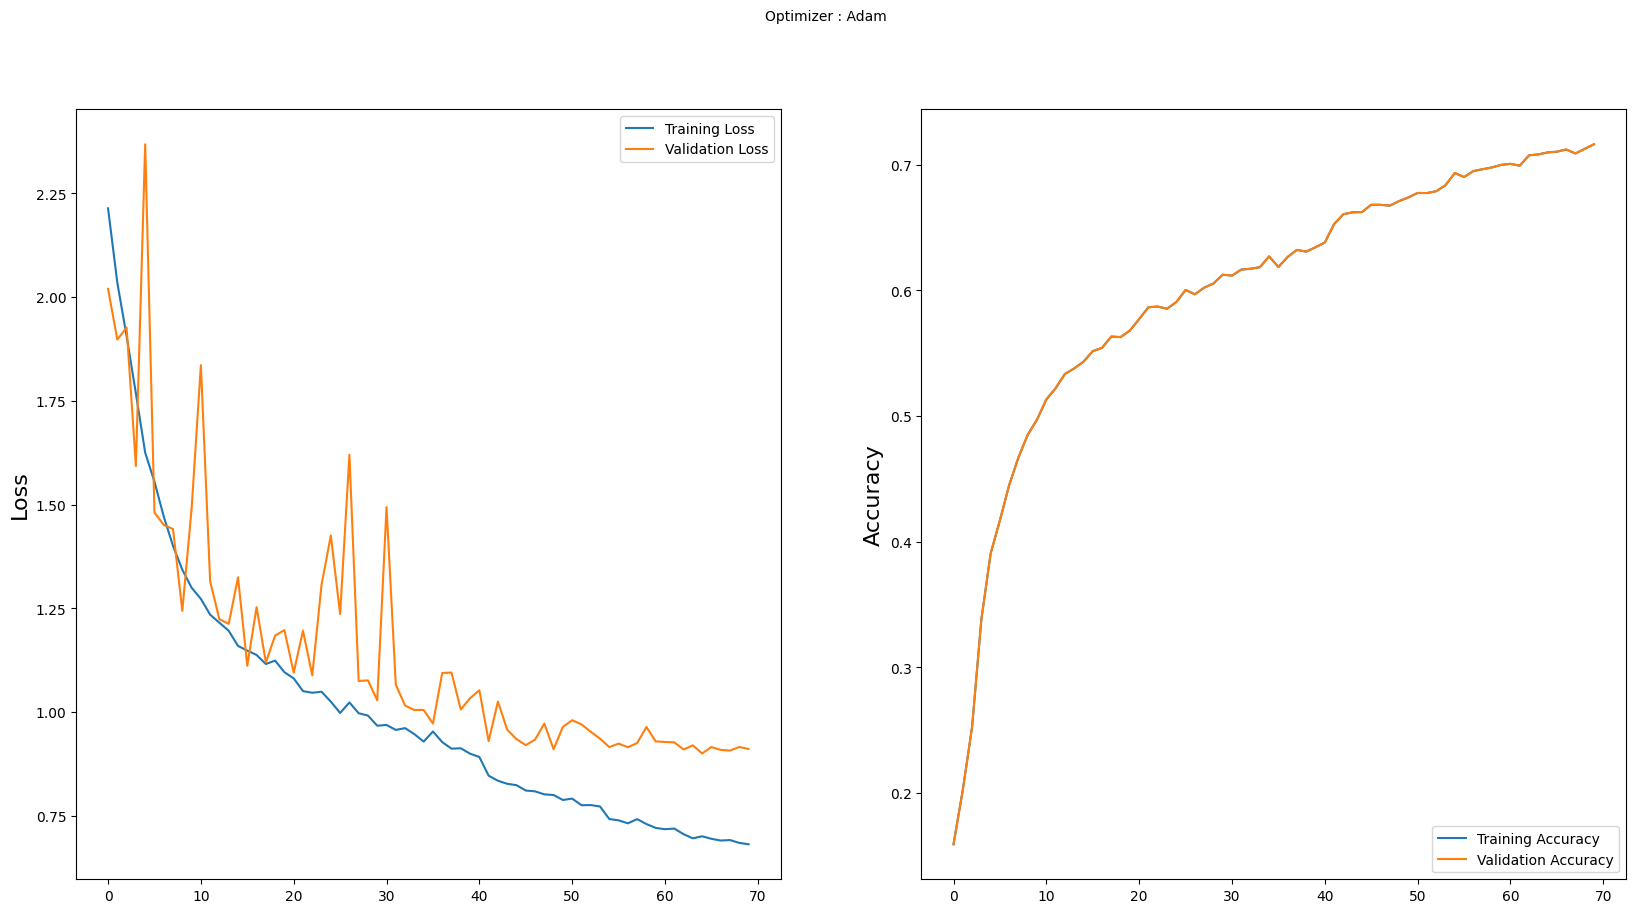

In [10]:
# plot the evolution of Loss and Acuracy on the train and validation sets


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step
Accuracy: 0.6842626662892726
Precision (weighted): 0.688440898762792
Recall (weighted): 0.6842626662892726
F1-score (weighted): 0.682165182906637

Classification report:
              precision    recall  f1-score   support

       angry       0.60      0.60      0.60       960
     disgust       0.65      0.76      0.70       111
        fear       0.60      0.44      0.51      1018
       happy       0.91      0.85      0.88      1825
     neutral       0.57      0.74      0.65      1216
         sad       0.58      0.53      0.56      1139
    surprise       0.75      0.84      0.79       797

    accuracy                           0.68      7066
   macro avg       0.66      0.68      0.67      7066
weighted avg       0.69      0.68      0.68      7066



<Figure size 640x480 with 0 Axes>

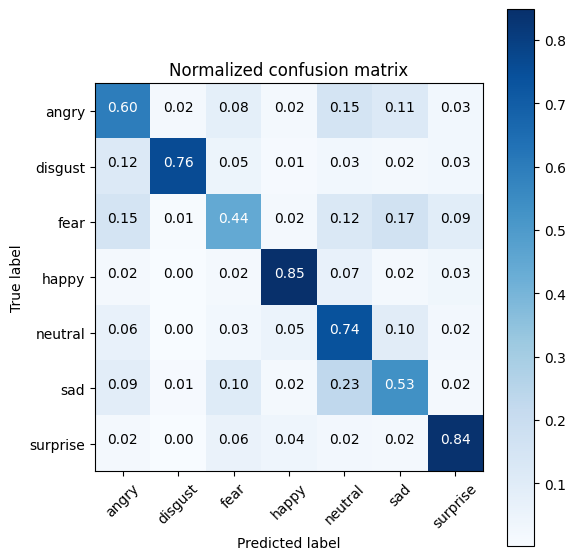

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import itertools

# 1. Get predictions on validation generator
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)           # predicted class indices
y_true = validation_generator.classes             # true class indices
class_names = list(validation_generator.class_indices.keys())

# 2. Basic metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_true, y_pred, average='weighted'))
print("F1-score (weighted):", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()